In [1]:
import sys
from pathlib import Path
ROOT = Path().resolve().parent.parent

sys.path.append(str(ROOT))

In [2]:
from src.model.data_handler import Dataset

dataset = Dataset(csv_data=ROOT / 'data/rec_data_description.csv', IMAGE_SIZE=(64, 64), include_filter=True)

data_update using version casarundata-2025.08.07-1.tar.gz, acquiring the lock ... 


lock file is not empty : /Users/luisvalenzuela/.casa/data/data_update.lock
data_update: the lock file at /Users/luisvalenzuela/.casa/data is not empty.
A previous attempt to update path may have failed or exited prematurely.
Remove the lock file and set force to True with the desired version (default to most recent).
It may be best to completely re-populate path using pull_data and measures_update.
2025-08-27 20:48:13	SEVERE	::casa	lock file is not empty : /Users/luisvalenzuela/.casa/data/data_update.lock
2025-08-27 20:48:13	SEVERE	::casa	data_update: the lock file at /Users/luisvalenzuela/.casa/data is not empty.
2025-08-27 20:48:13	SEVERE	::casa	A previous attempt to update path may have failed or exited prematurely.
2025-08-27 20:48:13	SEVERE	::casa	Remove the lock file and set force to True with the desired version (default to most recent).
2025-08-27 20:48:13	SEVERE	::casa	It may be best to completely re-populate path using pull_data and measures_update.
2025-08-27 20:48:13	SEVERE

In [3]:
metrics = ['ssim', 'psnr', 'residual_rms']
dataset.calculate_metrics(metrics=metrics, to_filter=True)

In [4]:
object_types = ['nebula', 'galaxy']

train, val, test, scalers = dataset.get_splits(
    train_ratio=0.70, 
    val_ratio=0.15, 
    test_ratio=0.15, 
    random_state=42,
    object_types=object_types,
    normalize_metrics=True
)

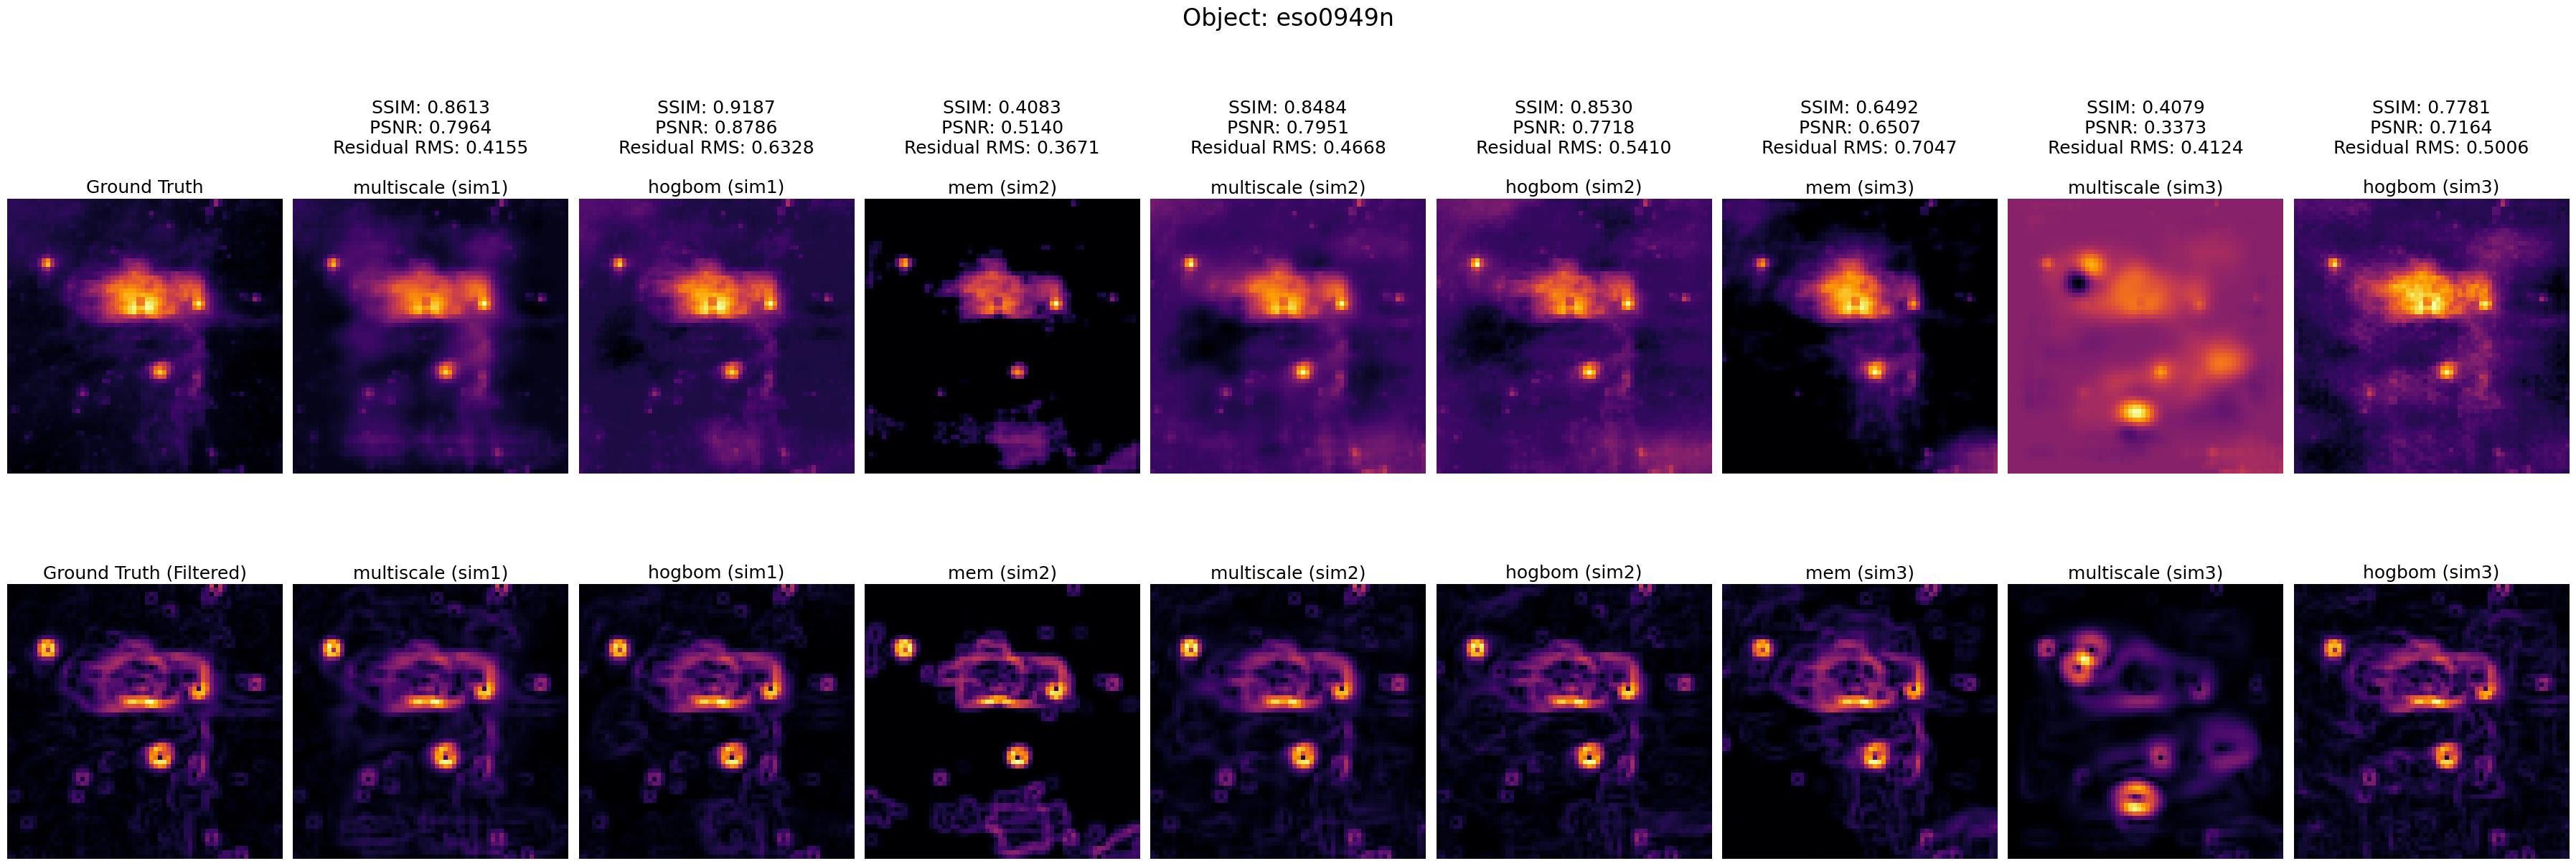

In [5]:
from src.model.utils.plot import plot_set

idx = 10
plot_set(train[idx], include_filtered=True, include_metrics=True)

In [6]:
from src.model.utils.prepare_data import prepare_data_for_model

grouped = True
include_filtered = False
y_score = 'ssim'

x_train, y_train = prepare_data_for_model(train, include_filtered=include_filtered, grouped=grouped, score=y_score)
x_val, y_val = prepare_data_for_model(val, include_filtered=include_filtered, grouped=grouped, score=y_score)
x_test, y_test = prepare_data_for_model(test, include_filtered=include_filtered, grouped=grouped, score=y_score)

In [7]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (210, 8, 64, 64), y_train shape: (210, 8)
x_val shape: (45, 8, 64, 64), y_val shape: (45, 8)
x_test shape: (45, 8, 64, 64), y_test shape: (45, 8)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam


def build_encoder():
    inp = Input((64, 64, 1))
    
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    
    # Paso a vector
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    
    return Model(inp, x)

encoder = build_encoder()

inp_group = Input((None, 64, 64, 1))

encoded = layers.TimeDistributed(encoder)(inp_group)
x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(encoded)
score = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)

model = Model(inp_group, score)
model.compile(optimizer=Adam(1e-4), loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 64, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128)      │     2,116,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 64)       │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 1)        │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,124,417 (8.10 MB)

 Trainable params: 2,124,417 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[early_stopping])

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0486 - val_loss: 0.0480
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0429 - val_loss: 0.0417
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0368 - val_loss: 0.0331
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0318 - val_loss: 0.0277
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0264 - val_loss: 0.0262
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.0242 - val_loss: 0.0237
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.0230 - val_loss: 0.0218
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0217 - val_loss: 0.0220
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0206 - val_loss: 0.0205
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.0179 - val_loss: 0.0184
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.0

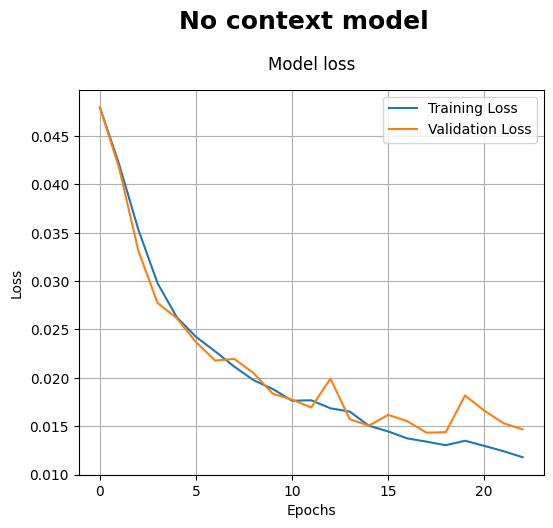

In [10]:
import matplotlib.pyplot as plt

history = model.history.history
plt.figure(figsize=(6, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.suptitle(f'No context model', fontsize=18, y=1.04, fontweight='bold')
plt.title('Model loss', y=1.03)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True)
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
MSE: 0.020
MAE: 0.108
R2 Score: 0.542


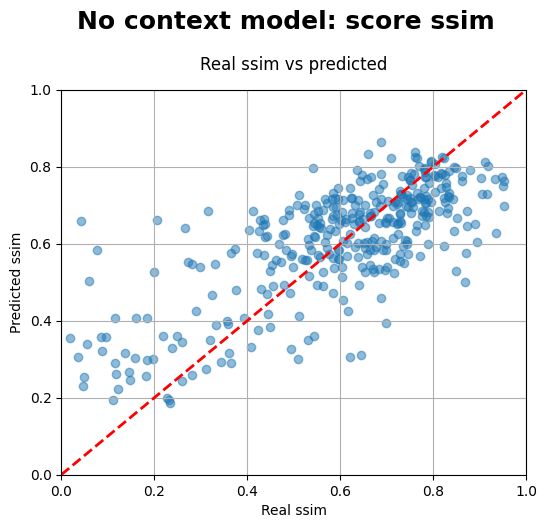

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(x_test)

y_pred_flattened = y_pred.flatten()
y_test_flattened = y_test.flatten()

print(f"MSE: {mean_squared_error(y_test_flattened, y_pred_flattened):.3f}")
print(f"MAE: {mean_absolute_error(y_test_flattened, y_pred_flattened):.3f}")
print(f"R2 Score: {r2_score(y_test_flattened, y_pred_flattened):.3f}")

test_max_ssim = max(y_test_flattened)

plt.figure(figsize=(6, 5))
plt.scatter(y_test_flattened, y_pred_flattened, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlabel(f'Real {y_score}')
plt.ylabel(f'Predicted {y_score}')
plt.suptitle(f'No context model: score {y_score}', fontsize=18, y=1.04, fontweight='bold')
plt.title(f'Real {y_score} vs predicted', y=1.03)

suma = 0.1 if test_max_ssim != 1 else 0
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()

In [12]:
y_pred_set = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [13]:
print(y_test.shape)
print(y_pred_set.shape)

(45, 8)
(45, 8, 1)


In [14]:
from scipy.stats import kendalltau, pearsonr, spearmanr

avg_kendalltau = 0
avg_pearsonr = 0
avg_spearmanr = 0

for y_test_i, y_pred_i in zip(y_test, y_pred_set):
    kendalltau_result, _ = kendalltau(y_test_i, y_pred_i.flatten())
    pearsonr_result, _ = pearsonr(y_test_i, y_pred_i.flatten())
    spearmanr_result, _ = spearmanr(y_test_i, y_pred_i.flatten())

    avg_kendalltau += kendalltau_result
    avg_pearsonr += pearsonr_result
    avg_spearmanr += spearmanr_result

avg_kendalltau /= len(y_test)
avg_pearsonr /= len(y_test)
avg_spearmanr /= len(y_test)

print(f"Average Kendall's Tau: {avg_kendalltau:.3f}")
print(f"Average Spearman's rho: {avg_spearmanr:.3f}")

Average Kendall's Tau: 0.657
Average Spearman's rho: 0.791


In [26]:
idx_test = 10

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ranked_reconstructions(ground_truth, reconstructions, scores, title, n=10, cmap='inferno'):
    sorted_indices = scores.argsort()[::-1][:n]

    num_images = len(sorted_indices) + 1

    fig, axes = plt.subplots(1, num_images, figsize=(2.3 * num_images, 3))

    axes[0].imshow(ground_truth, cmap=cmap)
    axes[0].set_title("Ground truth \nimage")
    axes[0].axis('off')

    for i, ax in enumerate(axes[1:], start=0):
        idx = sorted_indices[i]
        ax.imshow(reconstructions[idx].data, cmap=cmap)
        ax.set_title(f"Score: {scores[idx]:.3f}")
        ax.axis('off')

    plt.suptitle(title, fontsize=22, y=1.03, fontweight='bold')
    plt.tight_layout()
    plt.show()

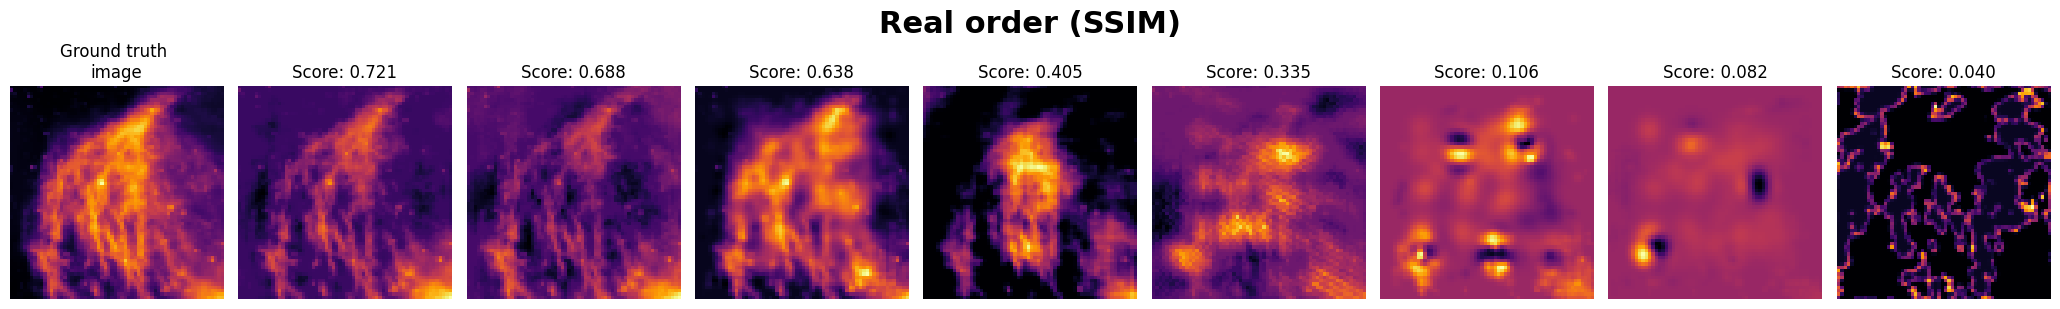

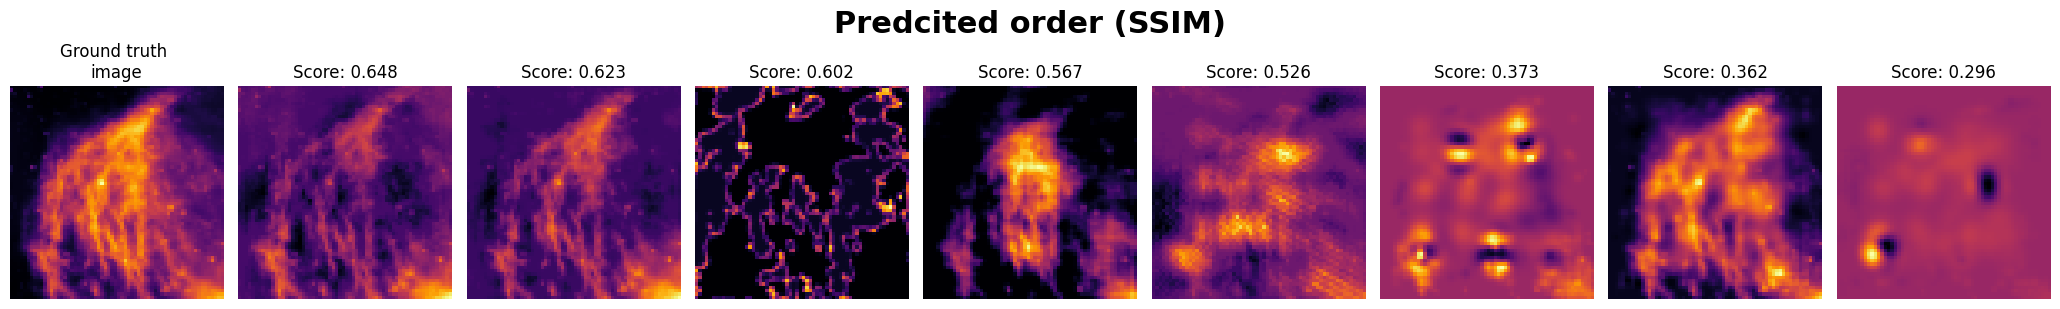

In [ ]:
real_scores = np.array([
    recon.metrics.ssim.value for recon in test[idx_test].reconstructions
])

ssim_scaler = scalers['ssim']
real_scores = ssim_scaler.inverse_transform(real_scores.reshape(-1, 1)).flatten()

pred_scores = y_pred_set[idx_test, :, 0]
pred_scores = ssim_scaler.inverse_transform(pred_scores.reshape(-1, 1)).flatten()


plot_ranked_reconstructions(
    ground_truth=test[idx_test].ground_truth.data,
    reconstructions=test[idx_test].reconstructions,
    scores=real_scores,
    title="Real order (SSIM)",
    n=8
)

plot_ranked_reconstructions(
    ground_truth=test[idx_test].ground_truth.data,
    reconstructions=test[idx_test].reconstructions,
    scores=pred_scores,
    title="Predicted order (SSIM)",
    n=8
)